¿Por qué recall?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier

In [2]:
train_df = pd.read_csv('diabetes_prediction_dataset_train-labeled.csv')
print(train_df.shape)
print(train_df.describe())

(95000, 10)
             patient           age  hypertension  heart_disease           bmi  \
count   95000.000000  95000.000000  95000.000000   95000.000000  95000.000000   
mean    50016.501389     41.935269      0.075074       0.039463     27.320879   
std     28868.357071     22.514788      0.263512       0.194695      6.626335   
min         1.000000      0.080000      0.000000       0.000000     10.010000   
25%     25021.750000     24.000000      0.000000       0.000000     23.650000   
50%     50024.000000     43.000000      0.000000       0.000000     27.320000   
75%     75024.250000     60.000000      0.000000       0.000000     29.580000   
max    100000.000000     80.000000      1.000000       1.000000     95.690000   

        HbA1c_level  blood_glucose_level      diabetes  
count  95000.000000         95000.000000  95000.000000  
mean       5.527659           138.070537      0.085074  
std        1.070261            40.739962      0.278993  
min        3.500000           

In [31]:
test_df = pd.read_csv('diabetes_prediction_dataset_test.csv')
print(test_df.shape)
print(test_df.describe())

(5000, 10)
            patient          age  hypertension  heart_disease          bmi  \
count   5000.000000  5000.000000   5000.000000    5000.000000  5000.000000   
mean   49696.473600    40.947016      0.070600       0.038600    27.318644   
std    28855.568156    22.537466      0.256181       0.192659     6.832943   
min        7.000000     0.160000      0.000000       0.000000    10.620000   
25%    24720.750000    23.000000      0.000000       0.000000    23.410000   
50%    49522.500000    41.000000      0.000000       0.000000    27.320000   
75%    74686.000000    59.000000      0.000000       0.000000    29.632500   
max    99970.000000    80.000000      1.000000       1.000000    88.760000   

       HbA1c_level  blood_glucose_level  diabetes  
count  5000.000000          5000.000000       0.0  
mean      5.524620           137.821000       NaN  
std       1.078559            40.101933       NaN  
min       3.500000            80.000000       NaN  
25%       4.800000        

## Análisis exploratorio de datos

In [4]:
train_df.columns

Index(['patient', 'gender', 'age', 'hypertension', 'heart_disease',
       'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level',
       'diabetes'],
      dtype='object')

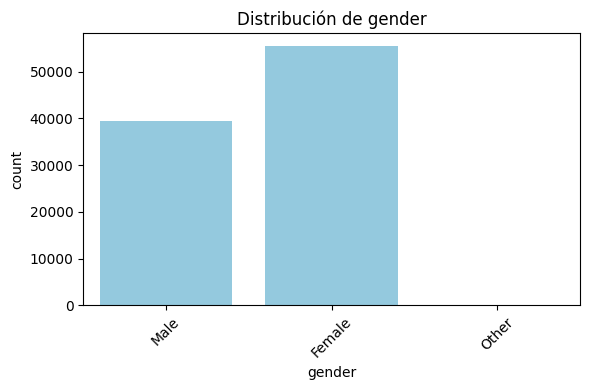

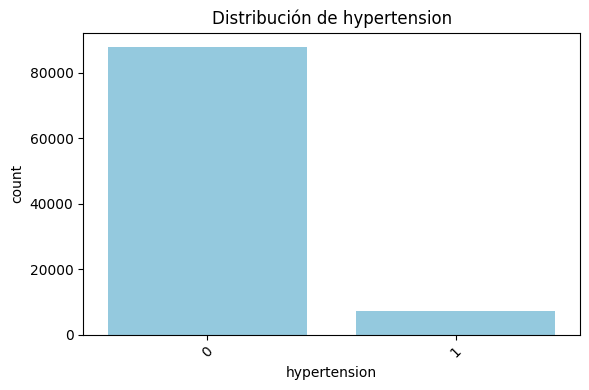

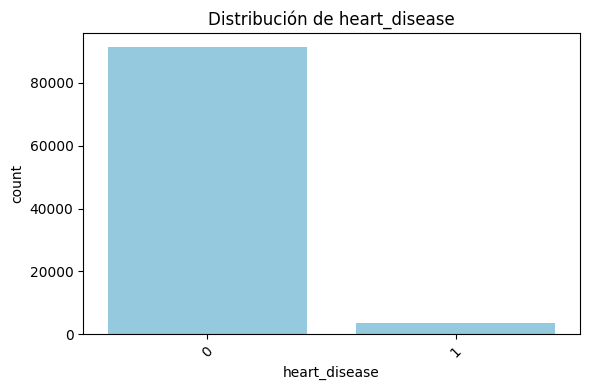

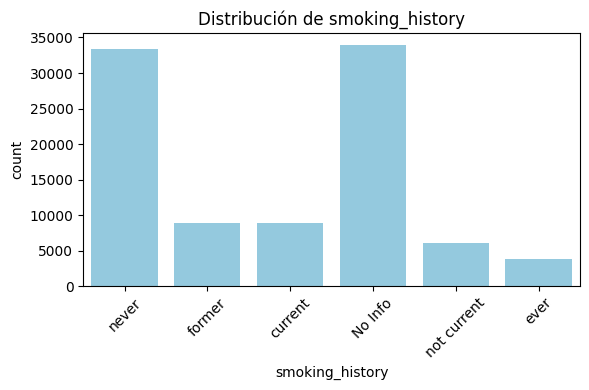

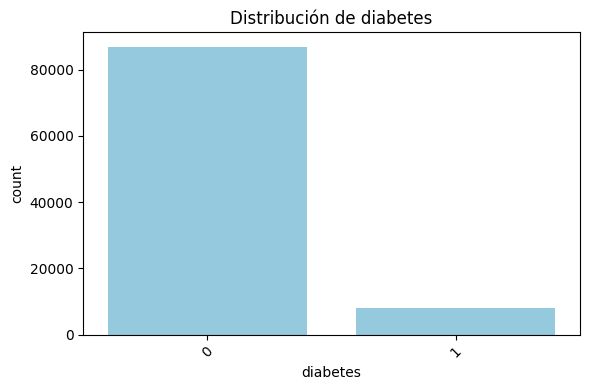

In [5]:
categorical_cols = ['gender', 'hypertension', 'heart_disease', 'smoking_history', 'diabetes']

for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=train_df, x=col, color = "skyblue", legend=False)
    plt.title(f'Distribución de {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


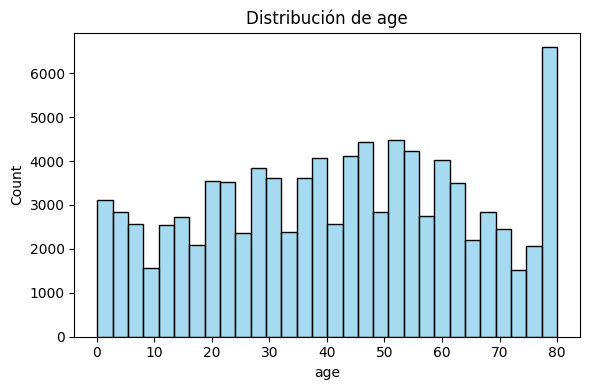

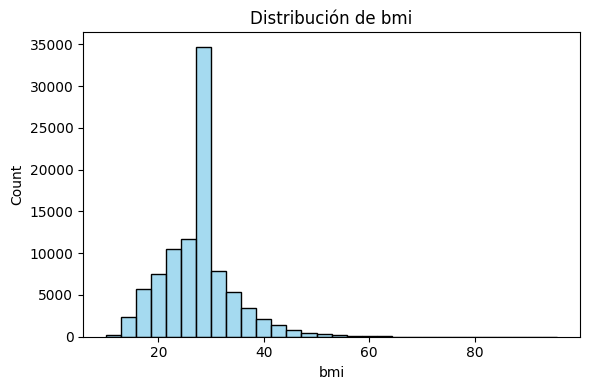

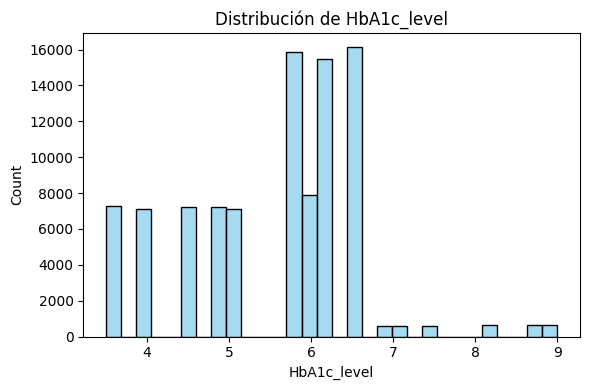

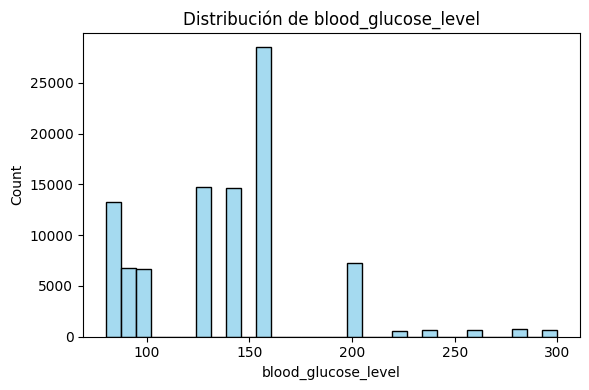

In [6]:
numeric_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=train_df, x=col, bins=30, color="skyblue")
    plt.title(f'Distribución de {col}')
    plt.tight_layout()
    plt.show()


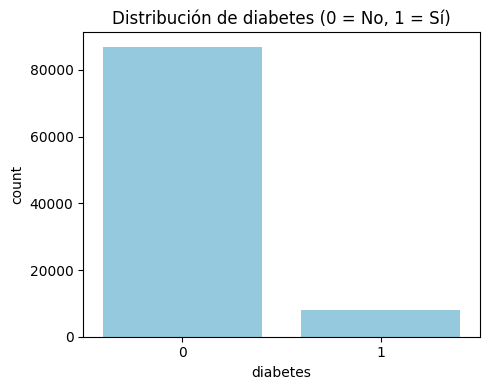

In [7]:
plt.figure(figsize=(5, 4))
sns.countplot(data=train_df, x='diabetes', color="skyblue")
plt.title('Distribución de diabetes (0 = No, 1 = Sí)')
plt.tight_layout()
plt.show()


## Probabilidad condicional

In [8]:
train_df['diabetes'].groupby(train_df['smoking_history']).mean()

smoking_history
No Info        0.040845
current        0.101916
ever           0.116825
former         0.170912
never          0.095211
not current    0.106216
Name: diabetes, dtype: float64

In [9]:
#sns.countplot(train_df['smoking_history'], hue=train_df['diabetes'])

ValueError: The following variable cannot be assigned with wide-form data: `hue`

## Modelo 1: Random Forest

### Procesamiento de datos

In [10]:
model = RandomForestClassifier()


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. Separar features y variable objetivo
X = train_df.drop(columns='diabetes')
y = train_df['diabetes']

# 2. Separar columnas numéricas y categóricas
numeric_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
categorical_features = ['gender', 'hypertension', 'heart_disease', 'smoking_history']

# 3. Preprocesamiento
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# 4. Crear pipeline completo
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# 5. Dividir datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


# 6. Entrenar
clf.fit(X_train, y_train)

# 7. Predecir y evaluar
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

recall = recall_score(y_test, y_pred)

print("📊 Classification Report:\n", classification_report(y_test, y_pred))
print("🧮 Matriz de Confusión:\n", confusion_matrix(y_test, y_pred))
print("Recall test: %.2f%%" % (recall * 100.0))



📊 Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     17384
           1       0.93      0.69      0.79      1616

    accuracy                           0.97     19000
   macro avg       0.95      0.84      0.89     19000
weighted avg       0.97      0.97      0.97     19000

🧮 Matriz de Confusión:
 [[17304    80]
 [  503  1113]]
Recall test: 68.87%


In [ ]:
grid = GridSearchCV(DecisionTreeClassifier(),
 {'criterion':('gini','entropy'),
 'splitter':("best","random"),
  'min_samples_leaf':(1, 2, 5),
  'min_samples_split':(2, 3, 5, 10, 50, 100),
 'max_depth':(5,10,20)})
grid.fit(x_train,y_train)
grid.best_params_

In [13]:
from sklearn.model_selection import GridSearchCV

# Definimos los parámetros que queremos probar
param_grid = {
    'classifier__n_estimators': [100, 200],           # 2 valores comunes
    'classifier__max_depth': [None, 10],              # sin límite vs. control moderado
    'classifier__min_samples_split': [2, 10],         # default vs. más conservador
    'classifier__min_samples_leaf': [1, 5],           # default vs. menos sobreajuste
    'classifier__max_features': ['sqrt', 0.5]         # default vs. más aleatoriedad
}


# Creamos el GridSearchCV, con recall como métrica
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='recall',
    cv=5,  # validación cruzada con 5 folds
    n_jobs=-1,
    verbose=2
)

# Ejecutamos la búsqueda en el conjunto de entrenamiento
grid_search.fit(X_train, y_train)

# Mostramos los mejores parámetros y el mejor recall obtenido
print("🔍 Mejor combinación de hiperparámetros:")
print(grid_search.best_params_)

print("\n📈 Mejor recall (media CV):", grid_search.best_score_)

# Evaluamos sobre el test final
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("\n📊 Classification Report (con test set):")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 32 candidates, totalling 160 fits


[CV] END classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=  21.2s
[CV] END classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=  22.7s
[CV] END classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=  23.5s
[CV] END classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=  23.0s
[CV] END classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=  25.0s
[CV] END classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_sample

In [16]:
# Mostramos los mejores parámetros y el mejor recall obtenido
print("🔍 Mejor combinación de hiperparámetros:")
print(grid_search.best_params_)

🔍 Mejor combinación de hiperparámetros:
{'classifier__max_depth': 10, 'classifier__max_features': 0.5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}


{'classifier__max_depth': 10, 'classifier__max_features': 0.5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}

In [21]:
print(confusion_matrix(y_test, y_pred))

[[15627  1757]
 [  146  1470]]


In [15]:
print("\n📈 Mejor recall (media CV):", grid_search.best_score_)



📈 Mejor recall (media CV): 0.9098371805859873


accuracy                           0.90     19000
   macro avg       0.72      0.90      0.77     19000
weighted avg       0.95      0.90      0.91     19000


In [14]:
best_model

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Predicción

In [24]:
feature_cols = ['gender', 'age', 'hypertension', 'heart_disease',
                'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level']
X_new = test_df[feature_cols]


In [25]:

# Columnas
numeric_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
categorical_features = ['gender', 'hypertension', 'heart_disease', 'smoking_history']

# Preprocesamiento
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Modelo con los mejores hiperparámetros
best_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=0.5,
    class_weight='balanced',
    random_state=42
)

# Pipeline completo
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_rf)
])

# Entrenar con todo el dataset original de entrenamiento
final_model.fit(X, y)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [33]:
# Predicción
test_id = test_df['patient']
test_pred = final_model.predict(X_new)

In [34]:
result_df = pd.DataFrame({
    'patient': test_id,
    'diabetes': test_pred
})

In [36]:
# Guardar CSV
result_df.to_csv("pred_diabetes_random_forest.csv", index=False)
